In [1]:
import os
import sys
os.environ["JAVA_HOME"] = "/home/jovyan/ivanova/env39_sim4rec_demo_new/lib/jvm"
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["OMP_NUM_THREADS"] = "32"
os.environ["NUMBA_NUM_THREADS"] = "4"

In [2]:
import random
import time
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

from pyspark import SparkConf
from pyspark.ml import PipelineModel
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
import pyspark.sql.functions as sf
from replay.data_preparator import Indexer

from sim4rec.modules import (
    CompositeGenerator, 
    evaluate_synthetic, 
    EvaluateMetrics, 
    RealDataGenerator, 
    Simulator,
    SDVDataGenerator
)
from sim4rec.recommenders.ucb import UCB
from sim4rec.response import (
    CosineSimilatiry, 
    BernoulliResponse, 
    NoiseResponse, 
    ParametricResponseFunction
)
from sim4rec.utils import pandas_to_spark

In [3]:
SPARK_LOCAL_DIR = './tmp'
CHECKPOINT_DIR = './tmp/checkpoints'

spark = SparkSession.builder\
    .appName('simulator')\
    .master('local[4]')\
    .config('spark.sql.shuffle.partitions', '4')\
    .config('spark.default.parallelism', '4')\
    .config('spark.driver.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.executor.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.sql.autoBroadcastJoinThreshold', '-1')\
    .config('spark.driver.memory', '4g')\
    .config('spark.local.dir', SPARK_LOCAL_DIR)\
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

24/09/12 14:50:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/12 14:50:27 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
24/09/12 14:50:28 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/09/12 14:50:28 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [4]:
np.random.seed(1234)

users_df = pd.DataFrame(
    data=np.random.normal(1, 1, size=(10000, 35)),
    columns=[f"user_attr_{i}" for i in range(35)],
)
items_df = pd.DataFrame(
    data=np.random.normal(-1, 1, size=(2000, 35)),
    columns=[f"item_attr_{i}" for i in range(35)],
)
items_df.loc[random.sample(range(2000), 1000)] = np.random.normal(1, 1, size=(1000, 35))
users_df["user_id"] = np.arange(len(users_df))
items_df["item_id"] = np.arange(len(items_df))
history_df_all = pd.DataFrame()
history_df_all["user_id"] = np.random.randint(0, 10000, size=33000)
history_df_all["item_id"] = np.random.randint(0, 2000, size=33000)
history_df_all["relevance"] = 0

users_matrix = users_df.values[history_df_all.values[:, 0], :-1]
items_matrix = items_df.values[history_df_all.values[:, 1], :-1]
dot = np.sum(users_matrix * items_matrix, axis=1)
history_df_all["relevance"] = np.where(dot >= 0.5, 1, 0)
history_df_all = history_df_all.drop_duplicates(
    subset=["user_id", "item_id"], ignore_index=True
)

history_df_train = history_df_all.iloc[:30000]
history_df_val = history_df_all.iloc[30000:]

users_df = pandas_to_spark(users_df)
items_df = pandas_to_spark(items_df)
history_df_train = pandas_to_spark(history_df_train)
history_df_val = pandas_to_spark(history_df_val)

## Divide users into strats

In [5]:
# Split users in half for demonstration purposes
users_cluster_1_df = users_df.filter(sf.col('user_id') < 5000)
users_cluster_2_df = users_df.filter(sf.col('user_id') >= 5000)

## Обучение генераторов

In [6]:
generator_1 = SDVDataGenerator(
    label='synth_strat_1',
    id_column_name='user_id',
    model_name='gaussiancopula',
    parallelization_level=4,
    device_name='cpu',
    seed=1234
)
generator_2 = SDVDataGenerator(
    label='synth_strat_2',
    id_column_name='user_id',
    model_name='gaussiancopula',
    parallelization_level=4,
    device_name='cpu',
    seed=1234
)

items_generator = RealDataGenerator(label='items_real', seed=1234)

generator_1.fit(users_cluster_1_df.drop('user_id'))
generator_2.fit(users_cluster_2_df.drop('user_id'))
items_generator.fit(items_df)

for g, d in zip([generator_1, generator_2], [users_cluster_1_df, users_cluster_2_df]):
    print(g.getLabel(), evaluate_synthetic(g.generate(d.count()).drop('user_id'), d.drop('user_id')))

users_com_generator = CompositeGenerator(
    generators=[generator_1, generator_2],
    label='users_composite',
    weights=[0.5, 0.5]
)
users_com_generator.generate(10000)

synth_strat_1 {'LogisticDetection': 1.0, 'SVCDetection': 0.8728538237964244, 'KSTest': 0.9855257142857143, 'ContinuousKLDivergence': 0.9671574151768041}


synth_strat_2 {'LogisticDetection': 1.0, 'SVCDetection': 0.8829795165716697, 'KSTest': 0.9846000000000001, 'ContinuousKLDivergence': 0.9670461996009401}


## Simulator initialization

In [9]:
CHECKPOINT_DIR = './tmp/checkpoints_pipe'
sim = Simulator(
    user_gen=users_com_generator,
    item_gen=items_generator,
    data_dir=f'{CHECKPOINT_DIR}/pipeline',
    user_key_col='user_id',
    item_key_col='item_id',
    spark_session=spark
)

## Response function

In [10]:
va_users = VectorAssembler(
    inputCols=users_df.columns[:-1],
    outputCol='features_usr'
)

va_items = VectorAssembler(
    inputCols=items_df.columns[:-1],
    outputCol='features_itm'
)

cos_sim = CosineSimilatiry(
    inputCols=["features_usr", "features_itm"],
    outputCol="cosine_proba"
)

noise_resp = NoiseResponse(mu=0.5, sigma=0.2, outputCol='noise_proba', seed=1234)

resp_func = ParametricResponseFunction(
    inputCols=['cosine_proba', 'noise_proba'],
    outputCol='proba',
    weights=[1.0, 0.0]
)
br = BernoulliResponse(inputCol='proba', outputCol='response')

cos_sim_model = PipelineModel(
    stages=[
        va_users,
        va_items,
        cos_sim,
        noise_resp,
        resp_func,
        br
    ]
)

In [11]:
test_df = history_df_train.join(users_df, 'user_id', 'left')\
                          .join(items_df, 'item_id', 'left')

lr_eval = EvaluateMetrics(
    userKeyCol='user_id',
    itemKeyCol='item_id',
    predictionCol='proba',
    labelCol='relevance',
    mllib_metrics=['areaUnderROC', 'areaUnderPR']
)
lr_eval(cos_sim_model.transform(test_df))

{'areaUnderROC': 0.9999995799798092, 'areaUnderPR': 0.9999996476688053}

## Recommendation algorithm training

In [12]:
indexer = Indexer(user_col='user_id', item_col='item_id')
indexer.fit(users=users_com_generator.sample(1.0), items=items_df)

model = UCB(sample=True)
model.fit(log=indexer.transform(history_df_train.limit(1)))

In [13]:
evaluator = EvaluateMetrics(
    userKeyCol='user_id',
    itemKeyCol='item_id',
    predictionCol='relevance',
    labelCol='response',
    mllib_metrics=['areaUnderROC']
)

spark.sparkContext.setLogLevel('ERROR')

In [14]:
metrics = []
for i in range(50):
    iter_time = time.time()
    ## sample a bunch of users
    users = sim.sample_users(0.02).cache()

    log = sim.get_log(users)
    if log is None:
        log = history_df_train.limit(1)
    log = log.cache()

    recs = model.predict(
        log=indexer.transform(log),
        k=10,
        users=indexer.transform(users),
        items=indexer.transform(items_df)
    )
    recs = indexer.inverse_transform(recs).cache()

    ## simulate responses on recommended items
    true_resp = sim.sample_responses(
        recs_df=recs,
        user_features=users,
        item_features=items_df,
        action_models=cos_sim_model
    ).select('user_id', 'item_id', 'relevance', 'response').cache()

    ## update log with simulated responses
    sim.update_log(true_resp, iteration=i)

    ## calculate metrics
    metrics.append(evaluator(true_resp))

    ## refit recommendation model
    model._clear_cache()
    train_log = sim.log.cache()
    model.fit(
        log=indexer.transform(
            train_log.select('user_id', 'item_id', 'response')\
                     .withColumnRenamed('response', 'relevance')
        )
    )

    users.unpersist()
    if log is not None:
        log.unpersist()
    recs.unpersist()
    true_resp.unpersist()
    train_log.unpersist()

    print(f'Iteration {i} finished in {time.time() - iter_time} sec.')

Iteration 0 finished in 714.7598996162415 sec.


Iteration 1 finished in 1335.8739750385284 sec.


Iteration 2 finished in 1470.569803237915 sec.


Iteration 3 finished in 1320.529712677002 sec.


Iteration 4 finished in 1256.9555077552795 sec.


Iteration 5 finished in 1540.5269601345062 sec.


Iteration 6 finished in 1572.0700194835663 sec.


Iteration 7 finished in 1830.9135689735413 sec.


Iteration 8 finished in 2320.38112616539 sec.


IOPub message rate exceeded.                                     (40 + 4) / 768]
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Iteration 16 finished in 2632.4666876792908 sec.


IOPub message rate exceeded. + 4) / 336][Stage 1820:>               (0 + 0) / 8]
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Iteration 20 finished in 2878.0975317955017 sec.


IOPub message rate exceeded.===>                                (283 + 4) / 768]
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Iteration 24 finished in 2687.7509372234344 sec.


IOPub message rate exceeded.==>                                 (180 + 4) / 519]
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Iteration 28 finished in 3155.4891357421875 sec.


KeyboardInterrupt: 

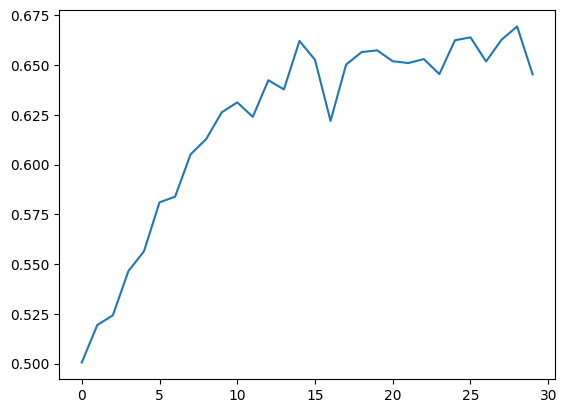

In [16]:
metrics_pdf = pd.DataFrame(metrics)
plt.plot(metrics_pdf['areaUnderROC'])